## Main code

### Libraries and Modules

In [1]:
import glob
import os
import time
import csv

import numpy as np
from scipy.spatial import Voronoi
import cv2

import import_ipynb
import tas #Threat Assessment Strategy: Voronoi
import pps #Path Planning Strategy: AGA and RHC
import pts #Path Tracking Strategy: Deadlock
import vertices_assembler as assembler
import utils

importing Jupyter notebook from tas.ipynb
importing Jupyter notebook from node_linker.ipynb
importing Jupyter notebook from pps.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from pts.ipynb
importing Jupyter notebook from vertices_assembler.ipynb


### Global Parameters

In [2]:
parameters = {"robots"      : 5,
              "radius"      : 0.1,
              "movement"    : 0.1,
              "tolerance"   : 0.05,
              "deadlock_mov": 0.1,
              "previous"    : 1
             }

### General Options

In [3]:
opt = { "palette"    : utils.colors(parameters["robots"]),
        "verbose"    : 1,
        "optimize"   : 0,
        "plot"       : 1,
        "zoom"       : 0,
        "save_image" : 0,
        "save_data"  : 0,
        "experiments": 1,
        "seed"       : 0,
        "breakpoint" : 100,
        "see_more_steps" : 100,
        "algorithm"  : "aga",
        "path_data"  : "/home/leduin/Escritorio/Tesis/Resultados/Datos/",
        "path_image" : "/home/leduin/Escritorio/Tesis/Imagenes/"
       }

### Main Loop

In [4]:
def main_module(key):
    with open(opt["path_data"]+opt["algorithm"]+key+".csv","a") as f:
        if opt["save_data"]:
            csv_writer = csv.writer(f)
        for experiment in range(opt["experiments"]):
            #--------------------------INITIALIZATION--------------------------
            start_time = time.time()
            inst_experiment = experiment + opt["seed"]
            robots_path = []
            # Generate pseudorandom positions and Voronoi attibutes
            pos = utils.pos_gen(parameters["robots"], inst_experiment)
            vor_i = Voronoi(pos["i"])
            vor_f = Voronoi(pos["f"])
            finished = np.all(pos["i"] == pos["f"]) 
            # To save the traveled distance of each robot 
            covered_dist = [0 for _ in range(parameters["robots"])]
            counter = 0 # For steps
            #-------------------COLLISION FREE CONFIGURATION-------------------
            if utils.collision(pos["i"], vor_i.ridge_points,
                               parameters["radius"]):
                print('ERROR!: Change the initial configuration')
                print("Positions:", vor_i.ridge_points)
                break
            if utils.collision(pos["f"], vor_f.ridge_points,
                               parameters["radius"]):
                print('ERROR!: Change the final configuration')
                print("Positions:", vor_f.ridge_points)
                break
            #-----------------------------MAIN LOOP----------------------------
            while not finished:
                #Final iteration
                if np.all(pos["i"] == pos["f"]):
                    finished = True
                if opt["verbose"]:
                    print("==================================================")
                    print('                    MAIN DATA')
                    print("==================================================")
                    print('\nRobots:\n', pos["i"],'\n\nFinal positions:\n', 
                          pos["f"],'\n\nColors:')
                    for color in opt["palette"]:
                        print(color)
                    print("\n")
                # Save the previous position
                robots_path.append(pos["i"])
                # Generate Voronoi attributes for the current positions
                vor_i = Voronoi(pos["i"])
                # Get the approximated values of inf vertices
                vor_prox = tas.vor_prox(pos["i"], vor_i, opt["verbose"])
                # Assemble the vertices and get the ordered vertices
                vrtx_assembled = assembler.main(parameters["robots"], vor_i,
                                                vor_prox["edge"],
                                                opt["verbose"])
                # TAS: Generate the BVC
                bvc = tas.bvc_gen(pos, parameters["radius"], vor_prox,
                                  robots_path, opt, vrtx_assembled)
                # PPS: Get the closer points
                closer = pps.controller(vrtx_assembled, pos, opt, 
                                        vor_i.ridge_points,
                                        parameters["radius"], bvc)
                # Plotting
                if opt["plot"]:
                    utils.plot(opt, vrtx_assembled, closer, pos, 
                               robots_path, vor_prox, bvc)
                utils.save_image(opt, parameters["robots"], counter)
                # PTS: Deadlock testing and solutions
                bvc, closer = pts.deadlock_test(parameters, opt, bvc, pos, 
                                                counter, robots_path, closer)
                if opt["verbose"]:
                    print('\nRounds: ',counter)
                    print('\n*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*\n')
                counter += 1
                if counter == opt["breakpoint"]:
                    opt["verbose"] = 1
                    opt["plot"] = 1
                if counter > opt["breakpoint"] + opt["see_more_steps"]:
                    opt["verbose"] = 0
                    opt["plot"] = 0
                # UPDATING POSITIONS
                covered_dist, pos = utils.update_pos(bvc, pos, parameters,
                                                     covered_dist, closer)
            effectiveness = np.sum(pos["dist"]) / np.sum(covered_dist)
            if opt["save_data"]:
                csv_writer.writerow([parameters[key], inst_experiment, counter,
                                     time.time() - start_time, effectiveness])
            print('Experiment ' + str(inst_experiment) + " done!")

### Running for the stablished number of experiments

                    MAIN DATA

Robots:
 [[ 2.94 -0.14]
 [ 0.69  2.83]
 [-2.58  1.55]
 [-2.77 -1.9 ]
 [ 0.49 -3.09]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.05862447 -0.07441248]
1 .- [-0.34006829 -0.30359044]
2 .- [-0.07511971 -0.12829041]
3 .- [79.65059034 60.31135632]
4 .- [-36.50929635  93.04566333]
5 .- [-34.63002974 -94.24079576]
6 .- [ 76.85377657 -64.01839071]
7 .- [-100.18876357    5.19532321]
Robots in front:  [[1 0]
 [1 2]
 [4 2]
 [4 3]
 [4 0]
 [2 0]
 [2 3]] 

Voronoi Diagram Edges:  [[3, 0], [4, 0], [1, 2], [5, 1], [6, 2], [0, 2], [7, 1]] 

             VORONOI VERTICES ASSEMBLY
Number of cells: 5 

--------------------------------------------------
Edge: [3, 0] ; Robots in front: [1, 0]
--------------------------------------------------
Robot N° 1 

Analysis of vertex 3 in the cell: empty
Anal

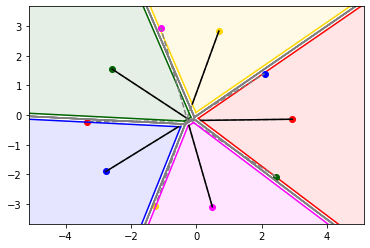

Closer positions: [[ 0.14359971 -0.17994858]
 [-0.12478161  0.3689417 ]
 [-0.25868568 -0.12983779]
 [-0.54943866 -0.39221143]
 [-0.2280974  -0.34941308]]
Deadlock?: False 


Rounds:  0

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.8400102  -0.14142843]
 [ 0.6585707   2.7350674 ]
 [-2.49898732  1.49137452]
 [-2.68726937 -1.84382488]
 [ 0.46465334 -2.99326559]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.05861642 -0.07423742]
1 .- [-0.33996688 -0.30342293]
2 .- [-0.07519645 -0.12845138]
3 .- [79.6202428  60.35157986]
4 .- [-36.70612926  92.96854737]
5 .- [-34.60079021 -94.25125944]
6 .- [ 76.76248701 -64.12822015]
7 .- [-100.18099961    5.33290404]
Robots in front:  [[1 0]
 [1 2]
 [4 2]
 [4 3]
 [4 0]
 [2 0]
 [2 3]] 

Voronoi Diagram Edges:  [[3, 0], [4, 0], [1, 2], 

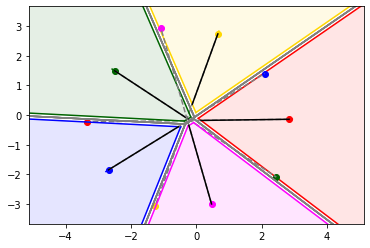

Distance from red to the closest point: 2.697391996453682
Distance from the 1th previous point: 2.797391996453682
Distance from gold to the closest point: 2.493757715465419
Distance from the 1th previous point: 2.5937577154654186
Distance from darkgreen to the closest point: 2.7653789710521544
Distance from the 1th previous point: 2.8653789710521544
Distance from blue to the closest point: 2.584833389192609
Distance from the 1th previous point: 2.6848333891926086
Distance from magenta to the closest point: 2.73315312537726
Distance from the 1th previous point: 2.83315312537726
Closer positions: [[ 0.14289341 -0.17995867]
 [-0.12519989  0.36767829]
 [-0.25867982 -0.12984204]
 [-0.54882055 -0.39179173]
 [-0.22810975 -0.34936595]]
Deadlock?: False 


Rounds:  1

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.74002041 -0.14285685]
 [ 0.6271414   2.64013479]
 [-2.41797465  1.43274905]
 [-2.60453875 -1.78764977]
 [ 0.43930668 -2.89653117]] 

Final 

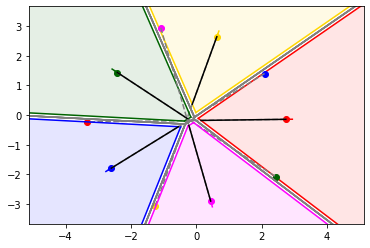

Distance from red to the closest point: 2.5981439353714024
Distance from the 1th previous point: 2.6981439353714025
Distance from gold to the closest point: 2.3951761374121214
Distance from the 1th previous point: 2.495176137412121
Distance from darkgreen to the closest point: 2.6653867016234507
Distance from the 1th previous point: 2.765386701623451
Distance from blue to the closest point: 2.4856303377173177
Distance from the 1th previous point: 2.5856303377173178
Distance from magenta to the closest point: 2.6332053339182986
Distance from the 1th previous point: 2.7332053339182982
Closer positions: [[ 0.14214155 -0.17996941]
 [-0.12564569  0.36633174]
 [-0.25867356 -0.12984657]
 [-0.54816123 -0.39134404]
 [-0.22812299 -0.34931544]]
Deadlock?: False 


Rounds:  2

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.64003061 -0.14428528]
 [ 0.5957121   2.54520219]
 [-2.33696197  1.37412357]
 [-2.52180812 -1.73147465]
 [ 0.41396001 -2.79979676]] 



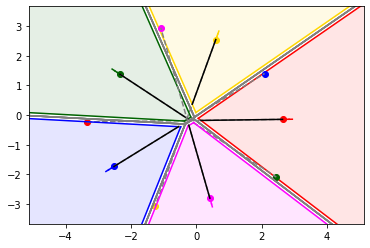

Distance from red to the closest point: 2.498945993351916
Distance from the 1th previous point: 2.5989459933519155
Distance from gold to the closest point: 2.2966910564645486
Distance from the 1th previous point: 2.3966910564645483
Distance from darkgreen to the closest point: 2.5653949762657113
Distance from the 1th previous point: 2.6653949762657114
Distance from blue to the closest point: 2.3864822544573423
Distance from the 1th previous point: 2.486482254457342
Distance from magenta to the closest point: 2.533261409680044
Distance from the 1th previous point: 2.6332614096800437
Closer positions: [[ 0.14133957 -0.17998086]
 [-0.12612182  0.36489359]
 [-0.25866685 -0.12985142]
 [-0.54745643 -0.39086548]
 [-0.2281372  -0.3492612 ]]
Deadlock?: False 


Rounds:  3

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.54004081 -0.1457137 ]
 [ 0.5642828   2.45026959]
 [-2.2559493   1.3154981 ]
 [-2.4390775  -1.67529954]
 [ 0.38861335 -2.70306235]] 

F

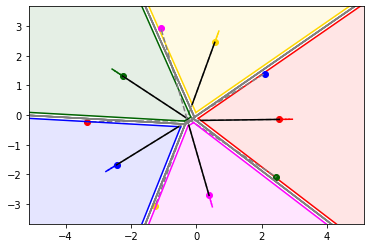

Distance from red to the closest point: 2.3998033511143824
Distance from the 1th previous point: 2.499803351114382
Distance from gold to the closest point: 2.1983126567496156
Distance from the 1th previous point: 2.2983126567496157
Distance from darkgreen to the closest point: 2.4654038541621484
Distance from the 1th previous point: 2.565403854162149
Distance from blue to the closest point: 2.287395026399023
Distance from the 1th previous point: 2.387395026399023
Distance from magenta to the closest point: 2.433321798783993
Distance from the 1th previous point: 2.533321798783993
Closer positions: [[ 0.1404823  -0.17999311]
 [-0.12663147  0.36335416]
 [-0.25865966 -0.12985663]
 [-0.54670129 -0.39035273]
 [-0.22815251 -0.34920278]]
Deadlock?: False 


Rounds:  4

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.44005101 -0.14714213]
 [ 0.5328535   2.35533698]
 [-2.17493662  1.25687262]
 [-2.35634687 -1.61912442]
 [ 0.36326669 -2.60632793]] 

Fina

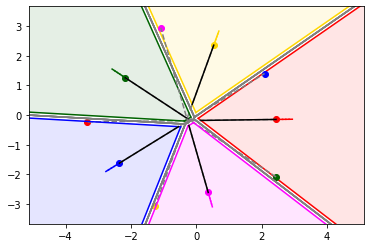

Distance from red to the closest point: 2.300721928408789
Distance from the 1th previous point: 2.4007219284087893
Distance from gold to the closest point: 2.1000526060294114
Distance from the 1th previous point: 2.200052606029411
Distance from darkgreen to the closest point: 2.3654134033365395
Distance from the 1th previous point: 2.46541340333654
Distance from blue to the closest point: 2.188375411755686
Distance from the 1th previous point: 2.288375411755686
Distance from magenta to the closest point: 2.333387018699671
Distance from the 1th previous point: 2.4333870186996704
Closer positions: [[ 0.13956382 -0.18000623]
 [-0.12717833  0.36170238]
 [-0.25865193 -0.12986222]
 [-0.54589021 -0.389802  ]
 [-0.22816904 -0.34913969]]
Deadlock?: False 


Rounds:  5

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.34006122 -0.14857055]
 [ 0.5014242   2.26040438]
 [-2.09392394  1.19824715]
 [-2.27361625 -1.5629493 ]
 [ 0.33792003 -2.50959352]] 

Final

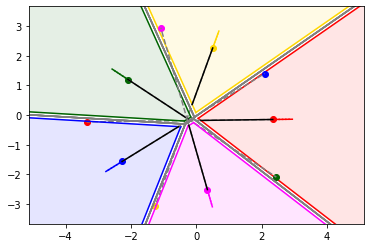

Distance from red to the closest point: 2.2017085205657
Distance from the 1th previous point: 2.3017085205657
Distance from gold to the closest point: 2.001924335701153
Distance from the 1th previous point: 2.101924335701153
Distance from darkgreen to the closest point: 2.2654237023514363
Distance from the 1th previous point: 2.3654237023514364
Distance from blue to the closest point: 2.089431207207194
Distance from the 1th previous point: 2.189431207207194
Distance from magenta to the closest point: 2.233457673098406
Distance from the 1th previous point: 2.3334576730984056
Closer positions: [[ 0.13857732 -0.18002032]
 [-0.1277666   0.3599255 ]
 [-0.25864358 -0.12986826]
 [-0.54501675 -0.3892089 ]
 [-0.22818694 -0.34907134]]
Deadlock?: False 


Rounds:  6

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.24007142 -0.14999898]
 [ 0.4699949   2.16547178]
 [-2.01291127  1.13962167]
 [-2.19088562 -1.50677419]
 [ 0.31257336 -2.41285911]] 

Final pos

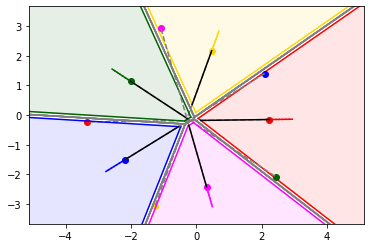

Distance from red to the closest point: 2.102770966456363
Distance from the 1th previous point: 2.2027709664563626
Distance from gold to the closest point: 1.9039433865877688
Distance from the 1th previous point: 2.003943386587769
Distance from darkgreen to the closest point: 2.165434842408154
Distance from the 1th previous point: 2.2654348424081543
Distance from blue to the closest point: 1.990571455167381
Distance from the 1th previous point: 2.090571455167381
Distance from magenta to the closest point: 2.133534470578148
Distance from the 1th previous point: 2.233534470578148
Closer positions: [[ 0.13751499 -0.1800355 ]
 [-0.12840117  0.35800876]
 [-0.25863456 -0.12987479]
 [-0.54407341 -0.38856837]
 [-0.22820641 -0.34899705]]
Deadlock?: False 


Rounds:  7

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.14008162 -0.15142741]
 [ 0.4385656   2.07053918]
 [-1.93189859  1.0809962 ]
 [-2.108155   -1.45059907]
 [ 0.2872267  -2.31612469]] 

Final

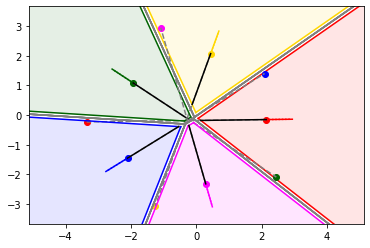

Distance from red to the closest point: 2.0039183566200256
Distance from the 1th previous point: 2.1039183566200252
Distance from gold to the closest point: 1.8061278392513695
Distance from the 1th previous point: 1.9061278392513696
Distance from darkgreen to the closest point: 2.0654469299619773
Distance from the 1th previous point: 2.165446929961977
Distance from blue to the closest point: 1.8918067027093282
Distance from the 1th previous point: 1.991806702709328
Distance from magenta to the closest point: 2.0336182484893506
Distance from the 1th previous point: 2.13361824848935
Closer positions: [[ 0.13636771 -0.18005189]
 [-0.12908773  0.355935  ]
 [-0.25862477 -0.12988188]
 [-0.54305148 -0.38787446]
 [-0.22822765 -0.34891601]]
Deadlock?: False 


Rounds:  8

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 2.04009182 -0.15285583]
 [ 0.4071363   1.97560657]
 [-1.85088592  1.02237072]
 [-2.02542437 -1.39442396]
 [ 0.26188004 -2.21939028]] 

Fi

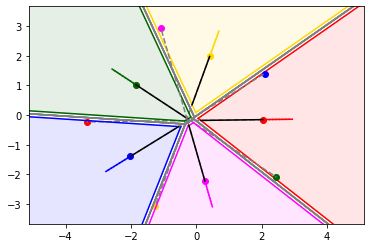

Distance from red to the closest point: 1.9051612932175312
Distance from the 1th previous point: 2.005161293217531
Distance from gold to the closest point: 1.7084988539011354
Distance from the 1th previous point: 1.8084988539011355
Distance from darkgreen to the closest point: 1.9654600900029784
Distance from the 1th previous point: 2.0654600900029783
Distance from blue to the closest point: 1.793149327802718
Distance from the 1th previous point: 1.8931493278027176
Distance from magenta to the closest point: 1.9337100035597183
Distance from the 1th previous point: 2.033710003559718
Closer positions: [[ 0.1351249  -0.18006964]
 [-0.12983293  0.35368414]
 [-0.2586141  -0.12988959]
 [-0.54194072 -0.38712024]
 [-0.2282509  -0.34882725]]
Deadlock?: False 


Rounds:  9

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.94010203 -0.15428426]
 [ 0.375707    1.88067397]
 [-1.76987324  0.96374525]
 [-1.94269375 -1.33824884]
 [ 0.23653338 -2.12265587]] 

F

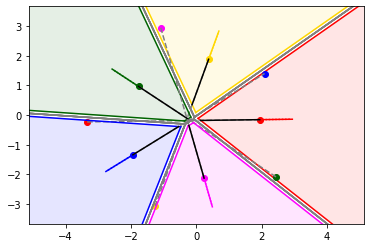

Distance from red to the closest point: 1.8065122174986958
Distance from the 1th previous point: 1.9065122174986957
Distance from gold to the closest point: 1.6110813538164055
Distance from the 1th previous point: 1.7110813538164056
Distance from darkgreen to the closest point: 1.8654744702038746
Distance from the 1th previous point: 1.9654744702038744
Distance from blue to the closest point: 1.6946139541766627
Distance from the 1th previous point: 1.7946139541766628
Distance from magenta to the closest point: 1.8338109316933937
Distance from the 1th previous point: 1.9338109316933936
Closer positions: [[ 0.13377412 -0.18008894]
 [-0.13064459  0.3512325 ]
 [-0.25860245 -0.12989803]
 [-0.54072903 -0.38629749]
 [-0.22827648 -0.34872962]]
Deadlock?: False 


Rounds:  10

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.84011223 -0.15571268]
 [ 0.3442777   1.78574137]
 [-1.68886057  0.90511977]
 [-1.85996312 -1.28207373]
 [ 0.21118672 -2.02592145]]

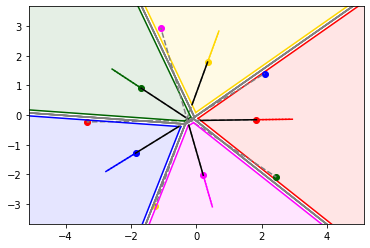

Distance from red to the closest point: 1.707985826136902
Distance from the 1th previous point: 1.8079858261369022
Distance from gold to the closest point: 1.5139048987209283
Distance from the 1th previous point: 1.6139048987209281
Distance from darkgreen to the closest point: 1.7654902462055997
Distance from the 1th previous point: 1.8654902462056
Distance from blue to the closest point: 1.5962179841873367
Distance from the 1th previous point: 1.6962179841873366
Distance from magenta to the closest point: 1.7339224803182234
Distance from the 1th previous point: 1.8339224803182232
Closer positions: [[ 0.13230066 -0.18010999]
 [-0.13153201  0.34855204]
 [-0.25858967 -0.12990727]
 [-0.539402   -0.38539642]
 [-0.22830476 -0.34862172]]
Deadlock?: False 


Rounds:  11

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.74012243 -0.15714111]
 [ 0.3128484   1.69080876]
 [-1.60784789  0.8464943 ]
 [-1.7772325  -1.22589861]
 [ 0.18584005 -1.92918704]] 

F

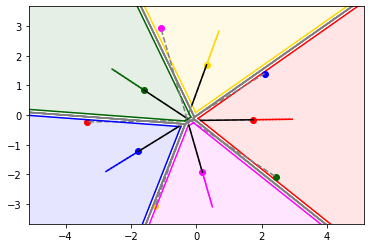

Distance from red to the closest point: 1.6095996058516242
Distance from the 1th previous point: 1.7095996058516243
Distance from gold to the closest point: 1.4170048124814112
Distance from the 1th previous point: 1.517004812481411
Distance from darkgreen to the closest point: 1.6655076284080994
Distance from the 1th previous point: 1.7655076284080995
Distance from blue to the closest point: 1.4979822907335876
Distance from the 1th previous point: 1.5979822907335877
Distance from magenta to the closest point: 1.63404641815036
Distance from the 1th previous point: 1.73404641815036
Closer positions: [[ 0.13068704 -0.18013304]
 [-0.13250629  0.34560921]
 [-0.25857559 -0.12991746]
 [-0.53794238 -0.38440532]
 [-0.22833617 -0.34850182]]
Deadlock?: False 


Rounds:  12

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.64013263 -0.15856953]
 [ 0.2814191   1.59587616]
 [-1.52683521  0.78786882]
 [-1.69450187 -1.16972349]
 [ 0.16049339 -1.83245263]] 

Fi

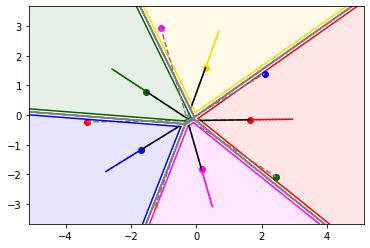

Distance from red to the closest point: 1.5113745274029686
Distance from the 1th previous point: 1.6113745274029687
Distance from gold to the closest point: 1.320423655593107
Distance from the 1th previous point: 1.4204236555931071
Distance from darkgreen to the closest point: 1.5655268707660734
Distance from the 1th previous point: 1.6655268707660735
Distance from blue to the closest point: 1.399932126397152
Distance from the 1th previous point: 1.499932126397152
Distance from magenta to the closest point: 1.5341849295304206
Distance from the 1th previous point: 1.6341849295304207
Closer positions: [[ 0.1289123  -0.1801584 ]
 [-0.13358081  0.34236361]
 [-0.25856    -0.12992875]
 [-0.53632927 -0.38331   ]
 [-0.22837128 -0.34836784]]
Deadlock?: False 


Rounds:  13

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.54014284 -0.15999796]
 [ 0.2499898   1.50094356]
 [-1.44582254  0.72924335]
 [-1.61177125 -1.11354838]
 [ 0.13514673 -1.73571821]] 



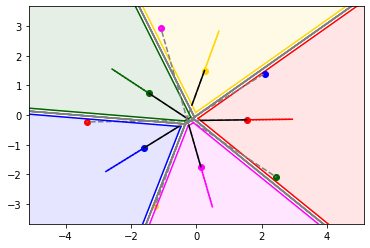

Distance from red to the closest point: 1.4133359571626825
Distance from the 1th previous point: 1.5133359571626823
Distance from gold to the closest point: 1.2242131714659539
Distance from the 1th previous point: 1.3242131714659537
Distance from darkgreen to the closest point: 1.465548282271235
Distance from the 1th previous point: 1.565548282271235
Distance from blue to the closest point: 1.3020983335861855
Distance from the 1th previous point: 1.4020983335861854
Distance from magenta to the closest point: 1.4343407440508984
Distance from the 1th previous point: 1.5343407440508987
Closer positions: [[ 0.12695107 -0.18018641]
 [-0.13477183  0.33876613]
 [-0.25854266 -0.1299413 ]
 [-0.53453715 -0.38209313]
 [-0.22841077 -0.34821711]]
Deadlock?: False 


Rounds:  14

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.44015304 -0.16142639]
 [ 0.2185605   1.40601095]
 [-1.36480986  0.67061787]
 [-1.52904062 -1.05737326]
 [ 0.10980007 -1.6389838 ]] 


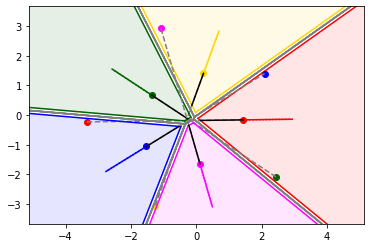

Distance from red to the closest point: 1.3155148700299695
Distance from the 1th previous point: 1.4155148700299693
Distance from gold to the closest point: 1.1284368934676563
Distance from the 1th previous point: 1.2284368934676562
Distance from darkgreen to the closest point: 1.3655722420462295
Distance from the 1th previous point: 1.4655722420462294
Distance from blue to the closest point: 1.2045189784366541
Distance from the 1th previous point: 1.3045189784366542
Distance from magenta to the closest point: 1.334517317890379
Distance from the 1th previous point: 1.4345173178903792
Closer positions: [[ 0.12477238 -0.18021754]
 [-0.13609931  0.33475644]
 [-0.25852325 -0.12995534]
 [-0.53253454 -0.38073333]
 [-0.22845553 -0.3480463 ]]
Deadlock?: False 


Rounds:  15

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.34016324 -0.16285481]
 [ 0.1871312   1.31107835]
 [-1.28379719  0.6119924 ]
 [-1.44631    -1.00119815]
 [ 0.0844534  -1.54224939]] 

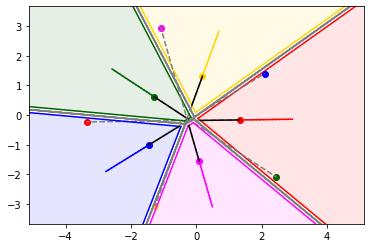

Distance from red to the closest point: 1.217949486347911
Distance from the 1th previous point: 1.317949486347911
Distance from gold to the closest point: 1.0331736883928455
Distance from the 1th previous point: 1.1331736883928454
Distance from darkgreen to the closest point: 1.2655992192857364
Distance from the 1th previous point: 1.3655992192857362
Distance from blue to the closest point: 1.107241591785229
Distance from the 1th previous point: 1.2072415917852288
Distance from magenta to the closest point: 1.2347190926096085
Distance from the 1th previous point: 1.3347190926096086
Closer positions: [[ 0.12233802 -0.18025231]
 [-0.13758805  0.33025968]
 [-0.25850139 -0.12997116]
 [-0.5302821  -0.3792039 ]
 [-0.22850667 -0.34785112]]
Deadlock?: False 


Rounds:  16

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.24017344 -0.16428324]
 [ 0.1557019   1.21614575]
 [-1.20278451  0.55336692]
 [-1.36357937 -0.94502303]
 [ 0.05910674 -1.44551497]] 



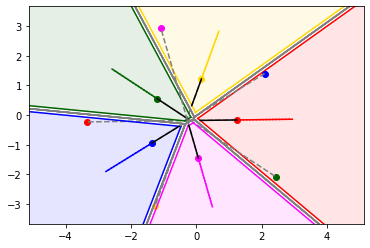

Distance from red to the closest point: 1.1206875158345204
Distance from the 1th previous point: 1.2206875158345205
Distance from gold to the closest point: 0.9385226505871469
Distance from the 1th previous point: 1.0385226505871468
Distance from darkgreen to the closest point: 1.1656297996297669
Distance from the 1th previous point: 1.265629799629767
Distance from blue to the closest point: 1.010326296755502
Distance from the 1th previous point: 1.110326296755502
Distance from magenta to the closest point: 1.1349518729328991
Distance from the 1th previous point: 1.2349518729328992
Closer positions: [[ 0.11960027 -0.18029142]
 [-0.13926919  0.32518177]
 [-0.25847662 -0.12998909]
 [-0.52773011 -0.37747106]
 [-0.22856567 -0.34762594]]
Deadlock?: False 


Rounds:  17

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.14018365 -0.16571166]
 [ 0.1242726   1.12121315]
 [-1.12177183  0.49474145]
 [-1.28084875 -0.88884791]
 [ 0.03376008 -1.34878056]] 



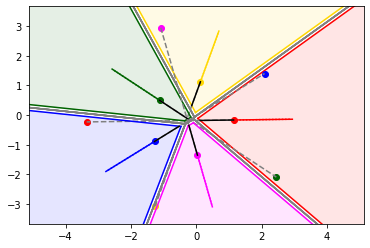

Distance from red to the closest point: 1.0237892873431744
Distance from the 1th previous point: 1.1237892873431745
Distance from gold to the closest point: 0.8446099820828125
Distance from the 1th previous point: 0.9446099820828123
Distance from darkgreen to the closest point: 1.0656647197988653
Distance from the 1th previous point: 1.1656647197988652
Distance from blue to the closest point: 0.9138502592322824
Distance from the 1th previous point: 1.0138502592322824
Distance from magenta to the closest point: 1.0352233925528556
Distance from the 1th previous point: 1.1352233925528556
Closer positions: [[ 0.11649881 -0.18033573]
 [-0.1411824   0.3194029 ]
 [-0.25844833 -0.13000956]
 [-0.52481471 -0.37549147]
 [-0.2286345  -0.34736329]]
Deadlock?: False 


Rounds:  18

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 1.04019385 -0.16714009]
 [ 0.0928433   1.02628054]
 [-1.04075916  0.43611597]
 [-1.19811812 -0.8326728 ]
 [ 0.00841342 -1.25204615]]

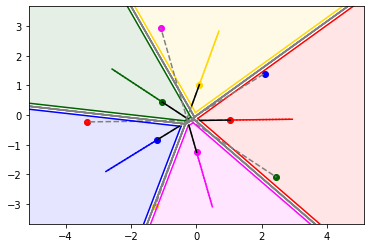

Distance from red to the closest point: 0.927332199078391
Distance from the 1th previous point: 1.027332199078391
Distance from gold to the closest point: 0.7515988552656442
Distance from the 1th previous point: 0.8515988552656442
Distance from darkgreen to the closest point: 0.9657049119688405
Distance from the 1th previous point: 1.0657049119688404
Distance from blue to the closest point: 0.8179141598562358
Distance from the 1th previous point: 0.9179141598562359
Distance from magenta to the closest point: 0.9355441868393803
Distance from the 1th previous point: 1.0355441868393804
Closer positions: [[ 0.11295626 -0.18038634]
 [-0.14337895  0.31276819]
 [-0.25841577 -0.13003312]
 [-0.52145262 -0.37320857]
 [-0.22871581 -0.34705297]]
Deadlock?: False 


Rounds:  19

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.94020405 -0.16856851]
 [ 0.061414    0.93134794]
 [-0.95974648  0.3774905 ]
 [-1.1153875  -0.77649768]
 [-0.01693324 -1.15531173]] 


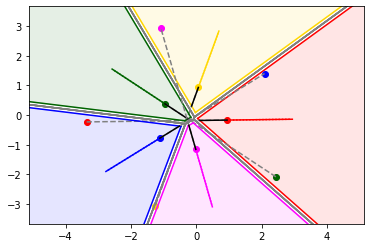

Distance from red to the closest point: 0.8314171842520339
Distance from the 1th previous point: 0.9314171842520339
Distance from gold to the closest point: 0.6597038591643457
Distance from the 1th previous point: 0.7597038591643457
Distance from darkgreen to the closest point: 0.8657515568403754
Distance from the 1th previous point: 0.9657515568403754
Distance from blue to the closest point: 0.72265183885321
Distance from the 1th previous point: 0.8226518388532101
Distance from magenta to the closest point: 0.8359289855889992
Distance from the 1th previous point: 0.9359289855889992
Closer positions: [[ 0.10887169 -0.18044469]
 [-0.1459263   0.30507389]
 [-0.25837798 -0.13006047]
 [-0.51753311 -0.37054717]
 [-0.22881334 -0.34668073]]
Deadlock?: False 


Rounds:  20

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.84021425 -0.16999694]
 [ 0.0299847   0.83641534]
 [-0.87873381  0.31886502]
 [-1.03265687 -0.72032257]
 [-0.04227991 -1.05857732]] 


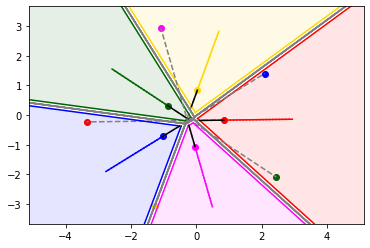

Distance from red to the closest point: 0.7361783354175179
Distance from the 1th previous point: 0.8361783354175178
Distance from gold to the closest point: 0.5692126686815246
Distance from the 1th previous point: 0.6692126686815247
Distance from darkgreen to the closest point: 0.7658061346927685
Distance from the 1th previous point: 0.8658061346927685
Distance from blue to the closest point: 0.628245072813578
Distance from the 1th previous point: 0.7282450728135781
Distance from magenta to the closest point: 0.7363990262917678
Distance from the 1th previous point: 0.8363990262917678
Closer positions: [[ 0.10411103 -0.1805127 ]
 [-0.14891485  0.29604693]
 [-0.25833376 -0.13009246]
 [-0.51290579 -0.36740517]
 [-0.22893248 -0.34622604]]
Deadlock?: False 


Rounds:  21

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.74022446 -0.17142536]
 [-0.0014446   0.74148273]
 [-0.79772113  0.26023955]
 [-0.94992624 -0.66414745]
 [-0.06762657 -0.96184291]] 

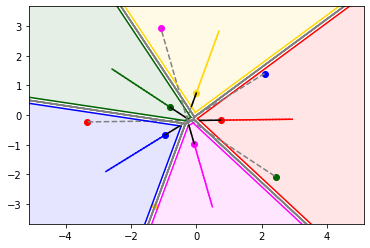

Distance from red to the closest point: 0.6417976283824125
Distance from the 1th previous point: 0.7417976283824126
Distance from gold to the closest point: 0.4805194045917387
Distance from the 1th previous point: 0.5805194045917387
Distance from darkgreen to the closest point: 0.665870430590018
Distance from the 1th previous point: 0.765870430590018
Distance from blue to the closest point: 0.534946938732738
Distance from the 1th previous point: 0.634946938732738
Distance from magenta to the closest point: 0.6369860831540778
Distance from the 1th previous point: 0.7369860831540778
Closer positions: [[ 0.09849231 -0.18059297]
 [-0.15246848  0.28531316]
 [-0.25828168 -0.13013016]
 [-0.5073613  -0.36364039]
 [-0.22908128 -0.34565816]]
Deadlock?: False 


Rounds:  22

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.64023466 -0.17285379]
 [-0.0328739   0.64655013]
 [-0.71670845  0.20161407]
 [-0.86719562 -0.60797233]
 [-0.09297323 -0.86510849]] 

F

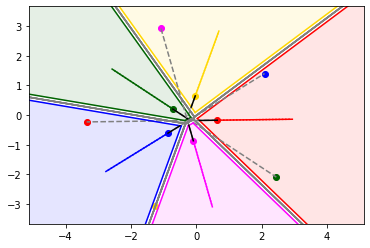

Distance from red to the closest point: 0.5485281586199245
Distance from the 1th previous point: 0.6485281586199246
Distance from gold to the closest point: 0.39417744329457244
Distance from the 1th previous point: 0.49417744329457247
Distance from darkgreen to the closest point: 0.5659463361298773
Distance from the 1th previous point: 0.6659463361298773
Distance from blue to the closest point: 0.44312010719108974
Distance from the 1th previous point: 0.5431201071910897
Distance from magenta to the closest point: 0.5377398988271523
Distance from the 1th previous point: 0.6377398988271524
Closer positions: [[ 0.09176246 -0.18068911]
 [-0.15676111  0.27234722]
 [-0.25822018 -0.13017466]
 [-0.50059958 -0.3590491 ]
 [-0.22927235 -0.34492896]]
Deadlock?: False 


Rounds:  23

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.54024486 -0.17428222]
 [-0.0643032   0.55161753]
 [-0.63569578  0.1429886 ]
 [-0.78446499 -0.55179722]
 [-0.11831989 -0.7683740

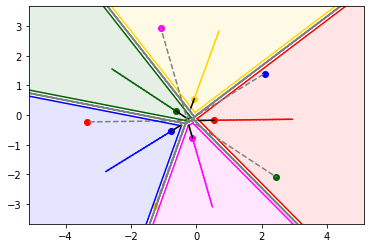

Distance from red to the closest point: 0.45673212900578897
Distance from the 1th previous point: 0.5567321290057891
Distance from gold to the closest point: 0.3109854204519195
Distance from the 1th previous point: 0.41098542045191955
Distance from darkgreen to the closest point: 0.4660348740263313
Distance from the 1th previous point: 0.5660348740263313
Distance from blue to the closest point: 0.3533022219181777
Distance from the 1th previous point: 0.45330222191817765
Distance from magenta to the closest point: 0.43874289667033445
Distance from the 1th previous point: 0.5387428966703345
Closer positions: [[ 0.08355933 -0.1808063 ]
 [-0.16204374  0.25639097]
 [-0.25814846 -0.13022656]
 [-0.49217586 -0.35332929]
 [-0.22952657 -0.34395871]]
Deadlock?: False 


Rounds:  24

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.44025506 -0.17571064]
 [-0.0957325   0.45668492]
 [-0.5546831   0.08436312]
 [-0.70173437 -0.4956221 ]
 [-0.14366655 -0.671639

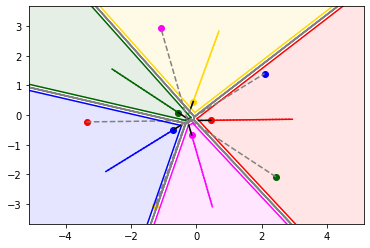

Distance from red to the closest point: 0.3669454813595765
Distance from the 1th previous point: 0.46694548135957653
Distance from gold to the closest point: 0.23213079821958843
Distance from the 1th previous point: 0.33213079821958846
Distance from darkgreen to the closest point: 0.3661321652687493
Distance from the 1th previous point: 0.46613216526874934
Distance from blue to the closest point: 0.2663227396697529
Distance from the 1th previous point: 0.3663227396697529
Distance from magenta to the closest point: 0.34014202091026186
Distance from the 1th previous point: 0.4401420209102619
Closer positions: [[ 0.07334702 -0.18095219]
 [-0.16868958  0.23631712]
 [-0.25806964 -0.1302836 ]
 [-0.4814039  -0.34601499]
 [-0.2298812  -0.34260528]]
Deadlock?: False 


Rounds:  25

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.34026527 -0.17713907]
 [-0.12716179  0.36175232]
 [-0.47367043  0.02573764]
 [-0.61900374 -0.43944699]
 [-0.16901322 -0.57490

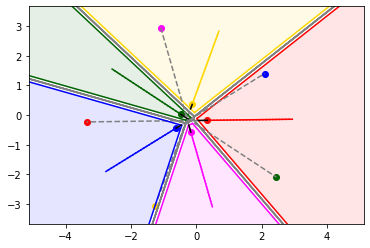

Distance from red to the closest point: 0.27999281908559537
Distance from the 1th previous point: 0.3799928190855954
Distance from gold to the closest point: 0.15943168648216002
Distance from the 1th previous point: 0.2594316864821601
Distance from darkgreen to the closest point: 0.2662116890690364
Distance from the 1th previous point: 0.3662116890690364
Distance from blue to the closest point: 0.183521961780931
Distance from the 1th previous point: 0.283521961780931
Distance from magenta to the closest point: 0.2422260612052956
Distance from the 1th previous point: 0.3422260612052956
Closer positions: [[ 0.06030101 -0.18113856]
 [-0.17727006  0.21039967]
 [-0.25800521 -0.13033022]
 [-0.46717488 -0.33635331]
 [-0.23040944 -0.3405893 ]]
Deadlock?: False 


Rounds:  26

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.24027547 -0.17856749]
 [-0.15859109  0.26681972]
 [-0.39265775 -0.03288783]
 [-0.53627312 -0.38327187]
 [-0.19435988 -0.47817084]]

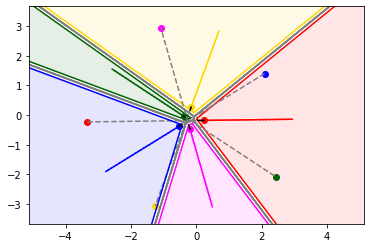

Distance from red to the closest point: 0.1972012122451739
Distance from the 1th previous point: 0.29720121224517393
Distance from gold to the closest point: 0.09572582259985365
Distance from the 1th previous point: 0.1957258225998537
Distance from darkgreen to the closest point: 0.16612779171117453
Distance from the 1th previous point: 0.2661277917111745
Distance from blue to the closest point: 0.10717734417302023
Distance from the 1th previous point: 0.2071773441730202
Distance from magenta to the closest point: 0.1456441182585165
Distance from the 1th previous point: 0.24564411825851648
Closer positions: [[ 0.04309438 -0.18138437]
 [-0.18867705  0.1759447 ]
 [-0.25807318 -0.13028104]
 [-0.44760463 -0.32306487]
 [-0.2312758  -0.33728286]]
Deadlock?: False 


Rounds:  27

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[ 0.14028567 -0.17999592]
 [-0.18867705  0.1759447 ]
 [-0.31164507 -0.09151331]
 [-0.45354249 -0.32709675]
 [-0.21970654 -0.38143

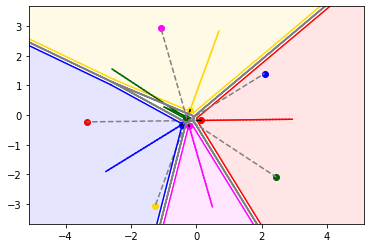

Distance from red to the closest point: 0.12081138119373504
Distance from the 1th previous point: 0.22081138119373506
Distance from gold to the closest point: 0.04747946686401896
Distance from the 1th previous point: 0.14320528946387262
Distance from darkgreen to the closest point: 0.06479388674180776
Distance from the 1th previous point: 0.16479388674180778
Distance from blue to the closest point: 0.029518147377502787
Distance from the 1th previous point: 0.1295181473775028
Distance from magenta to the closest point: 0.04300406256006888
Distance from the 1th previous point: 0.14300406256006887
Closer positions: [[ 0.01948662 -0.18172162]
 [-0.20359951  0.13087121]
 [-0.25915381 -0.12949903]
 [-0.42912195 -0.3105149 ]
 [-0.23060664 -0.3398367 ]]
Deadlock?: True 

Cells in Deadlock:
gold blue magenta 
Closer_edges: [[ 4.88421053e+01 -8.74321094e+01]
 [ 1.03988552e-02 -1.65480980e-01]
 [-8.61581838e-02  7.68757119e-02]
 [-2.52983619e+00  1.20039509e+00]
 [-1.81534400e-01 -1.04884867e-01]

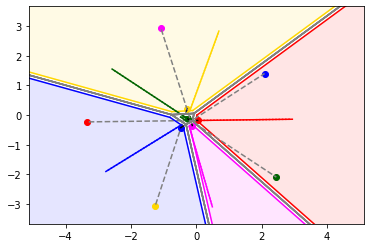

Distance from red to the closest point: 0.025855627346778088
Distance from the 1th previous point: 0.1258556273467781
Distance from gold to the closest point: 0.07785399783490542
Distance from the 1th previous point: 0.11902939498232855
Distance from darkgreen to the closest point: 0.03225160653136521
Distance from the 1th previous point: 0.09704549327317298
Distance from blue to the closest point: 0.08697415495867308
Distance from the 1th previous point: 0.0673621215116813
Distance from magenta to the closest point: 0.030768888822532182
Distance from the 1th previous point: 0.10526273057735218
Closer positions: [[ 0.01444288 -0.18179367]
 [-0.30259643  0.14144293]
 [-0.23302592 -0.14840669]
 [-0.40529329 -0.37410388]
 [-0.13304682 -0.32168415]]
Deadlock?: True 

Cells in Deadlock:
red darkgreen magenta 
Closer_edges: [[ 7.17727042e+01 -6.97829876e+01]
 [-8.62322707e-03 -1.59420934e-01]
 [-1.10830550e-01  1.53173252e-01]
 [-7.50121033e-01  1.14067847e-01]
 [-2.06949292e-01 -1.32555642e

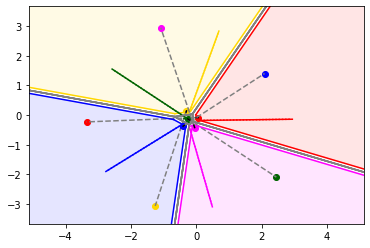

Distance from red to the closest point: 0.060294270234361756
Distance from the 1th previous point: 0.10519521456783741
Distance from gold to the closest point: 0.04130578672965239
Distance from the 1th previous point: 0.11915978456455781
Distance from darkgreen to the closest point: 0.08297630242575288
Distance from the 1th previous point: 0.08297630242575288
Distance from blue to the closest point: 0.04639055842039399
Distance from the 1th previous point: 0.13336471337906708
Distance from magenta to the closest point: 0.08269114892130736
Distance from the 1th previous point: 0.048313391146448954
Closer positions: [[-0.00285733 -0.08548773]
 [-0.3144312   0.10186887]
 [-0.19193249 -0.17814428]
 [-0.36748472 -0.34722274]
 [-0.0769923  -0.34181945]]
Deadlock?: True 

Cells in Deadlock:
gold blue magenta 
Closer_edges: [[ 0.00634476 -0.14798799]
 [-0.0168921   0.00983592]
 [-0.18195903  0.12310935]
 [-0.6596113   0.04652297]
 [-0.22330498 -0.20038688]
 [-0.19142441 -0.17778406]
 [-0.32641

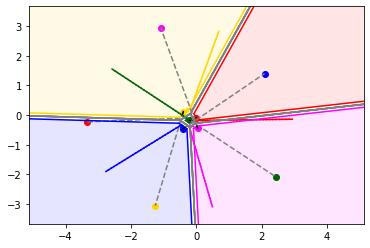

Distance from red to the closest point: 0.005762661037659732
Distance from the 1th previous point: 0.0660569312720215
Distance from gold to the closest point: 0.12513555375969915
Distance from the 1th previous point: 0.19543005327512253
Distance from darkgreen to the closest point: 0.011244112673477384
Distance from the 1th previous point: 0.09422041509923025
Distance from blue to the closest point: 0.08934805828973219
Distance from the 1th previous point: 0.07418180778154093
Distance from magenta to the closest point: 0.08624778641388282
Distance from the 1th previous point: 0.08473651602318541
Closer positions: [[-0.00861466 -0.08573556]
 [-0.43197488 -0.00502933]
 [-0.18282333 -0.1847362 ]
 [-0.34683858 -0.4197765 ]
 [ 0.01517229 -0.36997199]]
Deadlock?: True 

Cells in Deadlock:
red darkgreen 
Closer_edges: [[-7.31989930e-02  4.60553771e-02]
 [ 3.09596391e-02 -1.66490952e-01]
 [-2.62875961e-01  1.14249948e-01]
 [-5.30771811e-01 -7.47188746e-02]
 [-2.23138160e-01 -1.02469674e-01]
 [

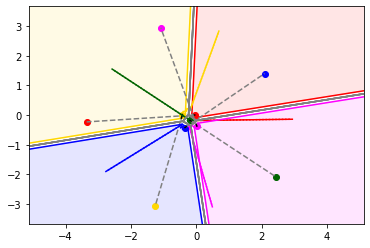

Distance from red to the closest point: 0.02226405313440251
Distance from the 1th previous point: 0.11097250313407092
Distance from gold to the closest point: 0.12485914214890344
Distance from the 1th previous point: 0.22485914214890346
Distance from darkgreen to the closest point: 0.0414488406983399
Distance from the 1th previous point: 0.0414488406983399
Distance from blue to the closest point: 0.04647902461562173
Distance from the 1th previous point: 0.1358270829053539
Distance from magenta to the closest point: 0.04692359601936327
Distance from the 1th previous point: 0.13317138243324608
Closer positions: [[-7.22220959e-02  1.13458647e-03]
 [-4.58062870e-01 -1.01280097e-01]
 [-1.58353675e-01 -2.02443861e-01]
 [-3.09597841e-01 -3.91965943e-01]
 [ 3.11376049e-04 -3.25463816e-01]]
Deadlock?: True 

Cells in Deadlock:
red darkgreen blue magenta 
Closer_edges: [[-0.13584284  0.05106283]
 [ 0.0245171  -0.07478433]
 [-0.33640868  0.04261957]
 [-0.46830144 -0.11339087]
 [-0.14926864 -0.192

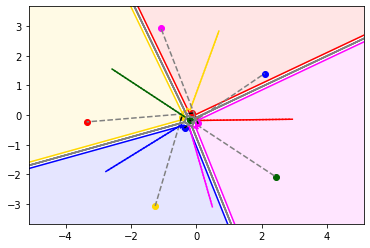

Distance from red to the closest point: 0.07474315293481125
Distance from the 1th previous point: 0.16266623071354822
Distance from gold to the closest point: 0.09340936368809694
Distance from the 1th previous point: 0.19340936368809694
Distance from darkgreen to the closest point: 0.030176708883162373
Distance from the 1th previous point: 0.030176708883162373
Distance from blue to the closest point: 0.04647902461562181
Distance from the 1th previous point: 0.04647902461562181
Distance from magenta to the closest point: 0.04415978963470373
Distance from the 1th previous point: 0.13735230413794802
Closer positions: [[-0.20311521  0.05765021]
 [-0.47599582 -0.1674431 ]
 [-0.16748553 -0.19583552]
 [-0.30959784 -0.39196594]
 [ 0.03296174 -0.23377657]]
Deadlock?: True 

Cells in Deadlock:
darkgreen blue magenta 
Closer_edges: [[-3.01462720e-02  1.25484449e-02]
 [-2.09801597e-01  5.93936889e-02]
 [-4.40208754e-01 -1.56500700e-01]
 [-9.60697936e+01 -2.93965846e+01]
 [-1.83482346e-01 -2.352464

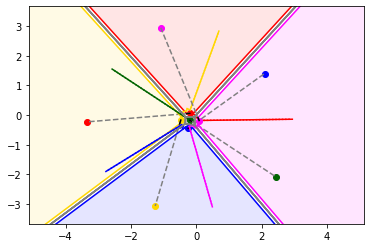

Distance from red to the closest point: 0.09306436199518849
Distance from the 1th previous point: 0.16780751492999973
Distance from gold to the closest point: 0.13512542770222127
Distance from the 1th previous point: 0.2285347913903182
Distance from darkgreen to the closest point: 0.04713144737964216
Distance from the 1th previous point: 0.04713144737964216
Distance from blue to the closest point: 0.046025934392933524
Distance from the 1th previous point: 0.13352997226511748
Distance from magenta to the closest point: 0.10086573632874758
Distance from the 1th previous point: 0.18707061498494482
Closer positions: [[-0.29579562  0.04920532]
 [-0.51134504 -0.29786286]
 [-0.15375004 -0.20577532]
 [-0.21341288 -0.41450048]
 [ 0.04977195 -0.08834822]]
Deadlock?: True 

Cells in Deadlock:
darkgreen blue 
Closer_edges: [[-2.84681641e-01  3.57318419e-02]
 [-6.39173923e+01  7.71776669e+01]
 [-4.36427421e-01 -2.36298277e-01]
 [-7.76963524e+01 -6.37256989e+01]
 [-1.54031867e-01 -2.22742029e-01]
 [

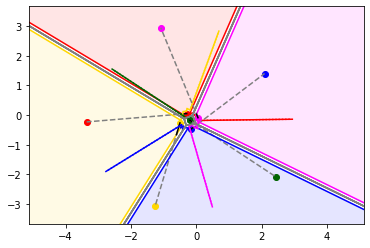

Distance from red to the closest point: 0.140319435322731
Distance from the 1th previous point: 0.2333837973179195
Distance from gold to the closest point: 0.403859492322552
Distance from the 1th previous point: 0.503859492322552
Distance from darkgreen to the closest point: 0.0518342941143161
Distance from the 1th previous point: 0.0518342941143161
Distance from blue to the closest point: 0.08441579565767861
Distance from the 1th previous point: 0.16587619458240235
Distance from magenta to the closest point: 0.1278570129978596
Distance from the 1th previous point: 0.2278570129978596
Closer positions: [[-0.43553615  0.03647239]
 [-0.60780699 -0.65375596]
 [-0.14994014 -0.20853238]
 [-0.08694893 -0.41027273]
 [ 0.00503987  0.0305039 ]]
Deadlock?: False 


Rounds:  35

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-0.39538306  0.04013107]
 [-0.52831642 -0.36047821]
 [-0.14994014 -0.20853238]
 [-0.08694893 -0.41027273]
 [ 0.01485237  0.00443231]] 

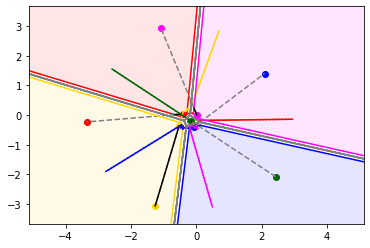

Distance from red to the closest point: 0.277773023827899
Distance from the 1th previous point: 0.377773023827899
Distance from darkgreen to the closest point: 0.007081699492436826
Distance from the 1th previous point: 0.058915993606752926
Distance from blue to the closest point: 0.014883449932813844
Distance from the 1th previous point: 0.09929924559049245
Distance from magenta to the closest point: 0.24509099219070293
Distance from the 1th previous point: 0.34509099219070294
Closer positions: [[-0.6720101   0.01492527]
 [-1.26       -3.06      ]
 [-0.14420307 -0.21268406]
 [-0.0755052  -0.40075653]
 [-0.07147978  0.23381486]]
Deadlock?: True 

Cells in Deadlock:
darkgreen blue 
Closer_edges: [[-4.04514438e-01 -7.38372754e-02]
 [-9.53156198e+01  3.14203222e+01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-2.47283068e-01 -2.44869663e-01]
 [-1.04139579e-01 -2.00174678e-01]
 [ 1.11960981e-01 -3.42222268e-01]
 [-2.13598075e-01 -4.43874514e-01]
 [ 8.58095159e+00

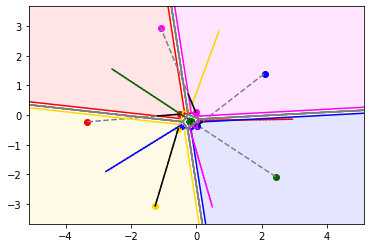

Distance from red to the closest point: 0.6924479243194298
Distance from the 1th previous point: 0.7924479243194298
Distance from darkgreen to the closest point: 0.01598158841615421
Distance from the 1th previous point: 0.01598158841615421
Distance from blue to the closest point: 0.22929841353479474
Distance from the 1th previous point: 0.32436985276062485
Distance from magenta to the closest point: 0.6405126090729942
Distance from the 1th previous point: 0.7405126090729942
Closer positions: [[-1.18456166 -0.0317776 ]
 [-1.26       -3.06      ]
 [-0.13699303 -0.21790166]
 [ 0.18205088 -0.22901352]
 [-0.2459897   0.69748378]]
Deadlock?: True 

Cells in Deadlock:
darkgreen 
Closer_edges: [[-4.65524953e-01 -1.19446760e-01]
 [-9.97304152e+01  1.19835098e+01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-2.44154176e-01 -3.17620137e-01]
 [-8.08366212e-02 -1.65645494e-01]
 [ 9.99690261e+01  5.64995790e+00]
 [ 1.42125775e-01 -2.31365712e-01]
 [-1.41312225e+01  9.9103

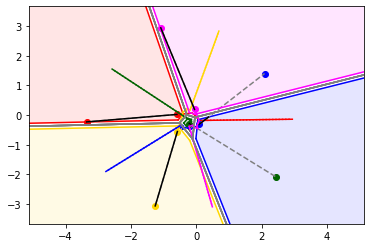

Distance from darkgreen to the closest point: 0.057190507493959854
Distance from the 1th previous point: 0.10925558693526784
Distance from blue to the closest point: 0.3818883398450509
Distance from the 1th previous point: 0.4818883398450509
Closer positions: [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [-0.16795592 -0.31629237]
 [ 0.37414807 -0.06500028]
 [-1.09        2.94      ]]
Deadlock?: False 


Rounds:  38

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-0.69414538  0.01290834]
 [-0.60679734 -0.65003087]
 [-0.16795592 -0.31629237]
 [ 0.15976914 -0.24803774]
 [-0.09082122  0.28520462]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.52511596 -0.3020446 ]
1 .- [ 0.19810633 -1.25302836]
2 .- [-0.32979365  0.01015565]
3 .- [-0.05770759 -0.02473609]
4 .- [-99.

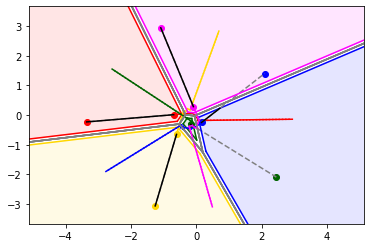

Distance from darkgreen to the closest point: 0.09679082166354351
Distance from the 1th previous point: 0.15398132915750337
Distance from blue to the closest point: 0.7365027417236016
Distance from the 1th previous point: 0.8365027417236017
Closer positions: [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [-0.08782459 -0.37058264]
 [ 0.71988691  0.23019273]
 [-1.09        2.94      ]]
Deadlock?: False 


Rounds:  39

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-0.79373282  0.00383409]
 [-0.63295764 -0.74654843]
 [-0.08782459 -0.37058264]
 [ 0.23582015 -0.18310513]
 [-0.12604574  0.3787954 ]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.51832265 -0.32957209]
1 .- [ 3.37248783 -5.97106786]
2 .- [-0.3478557 -0.0081815]
3 .- [-0.08927004  0.00500736]
4 .- [-98.299

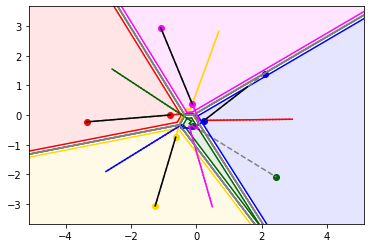

Distance from darkgreen to the closest point: 0.1999259567735773
Distance from the 1th previous point: 0.2967167784371208
Distance from blue to the closest point: 1.7456606284497436
Distance from the 1th previous point: 1.8456606284497437
Closer positions: [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [ 0.0776904  -0.48272174]
 [ 1.56341266  0.95039792]
 [-1.09        2.94      ]]
Deadlock?: False 


Rounds:  40

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-0.89332026 -0.00524015]
 [-0.65911794 -0.84306598]
 [-0.00503645 -0.42667296]
 [ 0.31187116 -0.11817252]
 [-0.16127027  0.47238617]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.51305247 -0.35058858]
1 .- [-0.35858497 -0.02500647]
2 .- [-0.12666753  0.01529494]
3 .- [ 53.18912343 -84.70742768]
4 .- [ 69.6

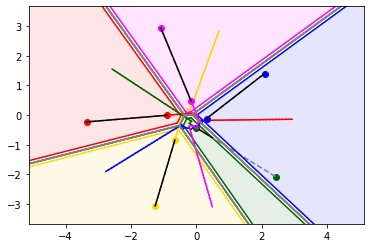

Distance from darkgreen to the closest point: 0.5997829487569427
Distance from the 1th previous point: 0.6997829487569427
Closer positions: [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [ 0.49151273 -0.76309308]
 [ 2.09        1.4       ]
 [-1.09        2.94      ]]
Deadlock?: False 


Rounds:  41

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-0.9929077  -0.0143144 ]
 [-0.68527825 -0.93958354]
 [ 0.0777517  -0.48276327]
 [ 0.38792217 -0.0532399 ]
 [-0.1964948   0.56597694]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50958121 -0.36739434]
1 .- [-0.36567554 -0.03849193]
2 .- [-0.15960939  0.01539455]
3 .- [ 50.85748099 -86.16614095]
4 .- [ 80.9119728  -58.52859371]
5 .- [-95.40229941 -31.9169115 ]
6 .- [-59.25463668  80.78285584]
7 .- [72.56509044 68.65297925

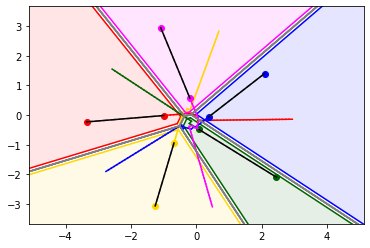

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  42

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.09249513 -0.02338864]
 [-0.71143855 -1.03610109]
 [ 0.16053984 -0.53885358]
 [ 0.46397318  0.01169271]
 [-0.23171933  0.65956771]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50714006 -0.38118212]
1 .- [-0.37061285 -0.04930044]
2 .- [-0.18610517  0.01109137]
3 .- [ 49.02969292 -87.24948577]
4 .- [ 87.3929398  -48.25805905]
5 .- [-94.10082157 -35.59797897]
6 .- [-62.52528396  78.28840989]
7 .- [67.9648356  73.19202654]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

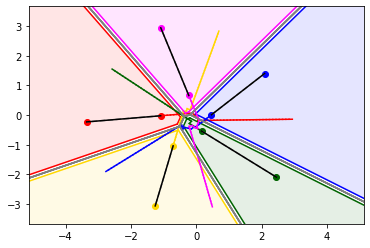

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  43

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.19208257 -0.03246289]
 [-0.73759885 -1.13261865]
 [ 0.24332799 -0.59494389]
 [ 0.54002419  0.07662532]
 [-0.26694385  0.75315848]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.5053396  -0.39271694]
1 .- [-0.37420181 -0.05806284]
2 .- [-0.20686816  0.00527482]
3 .- [ 47.56054176 -88.08348641]
4 .- [ 91.26399187 -40.40613156]
5 .- [-92.92936093 -38.57386781]
6 .- [-65.10332763  76.16621328]
7 .- [64.03881744 76.6374605 ]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

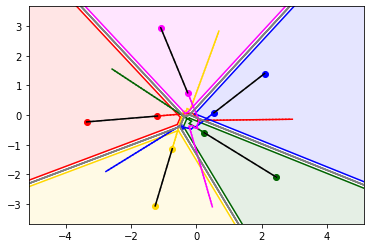

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  44

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.29167001 -0.04153714]
 [-0.76375916 -1.22913621]
 [ 0.32611613 -0.6510342 ]
 [ 0.61607519  0.14155793]
 [-0.30216838  0.84674926]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50396262 -0.40251875]
1 .- [-0.37690401 -0.06526749]
2 .- [-0.22313275 -0.00076411]
3 .- [ 46.35502009 -88.74410431]
4 .- [ 93.68967516 -34.35748851]
5 .- [-91.88257443 -41.02208673]
6 .- [-67.17921208  74.34878788]
7 .- [60.68552761 79.30960781]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

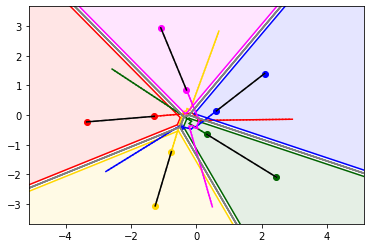

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  45

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.39125745 -0.05061138]
 [-0.78991946 -1.32565376]
 [ 0.40890428 -0.70712452]
 [ 0.6921262   0.20649055]
 [-0.33739291  0.94034003]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50287894 -0.41095586]
1 .- [-0.37899835 -0.07127475]
2 .- [-0.2359991  -0.00649646]
3 .- [ 45.34862284 -89.27962178]
4 .- [ 95.27969639 -29.61649334]
5 .- [-90.9486955  -43.06718949]
6 .- [-68.88169612  72.78049529]
7 .- [57.80811526 81.4237239 ]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

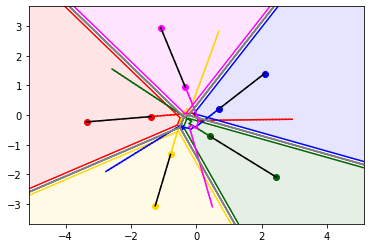

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  46

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.49084489 -0.05968563]
 [-0.81607977 -1.42217132]
 [ 0.49169242 -0.76321483]
 [ 0.76817721  0.27142316]
 [-0.37261744  1.0339308 ]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50200612 -0.41829761]
1 .- [-0.38066115 -0.07634885]
2 .- [-0.24631469 -0.01173697]
3 .- [ 44.49613246 -89.72209106]
4 .- [ 96.36365189 -25.82867635]
5 .- [-90.11449504 -44.79849397]
6 .- [-70.30021851  71.41669625]
7 .- [55.32345637 83.12670507]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

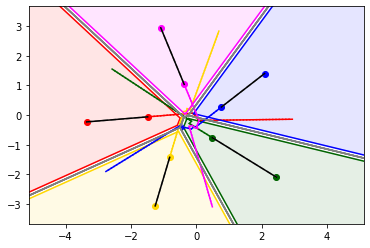

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  47

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.59043233 -0.06875987]
 [-0.84224007 -1.51868887]
 [ 0.57448057 -0.81930514]
 [ 0.84422822  0.33635577]
 [-0.40784197  1.12752157]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50128953 -0.42474604]
1 .- [-0.38200837 -0.08068508]
2 .- [-0.25470327 -0.01644995]
3 .- [ 43.76496685 -90.0935731 ]
4 .- [ 97.12767507 -22.74687862]
5 .- [-89.36730636 -46.28138191]
6 .- [-71.49846865  70.22186877]
7 .- [53.163159   84.52071342]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

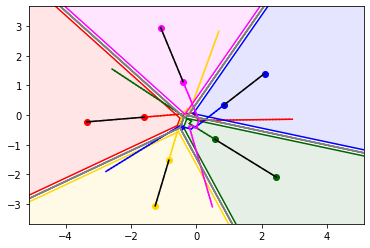

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  48

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.69001977 -0.07783412]
 [-0.86840037 -1.61520643]
 [ 0.65726871 -0.87539545]
 [ 0.92027923  0.40128838]
 [-0.44306649  1.22111234]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50069168 -0.43045592]
1 .- [-0.38311889 -0.08442957]
2 .- [-0.26161904 -0.02066135]
3 .- [ 43.13108221 -90.40972191]
4 .- [ 97.68160192 -20.19801171]
5 .- [-88.69575673 -47.56463142]
6 .- [-72.52283118  69.16773221]
7 .- [51.2718919  85.67821408]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

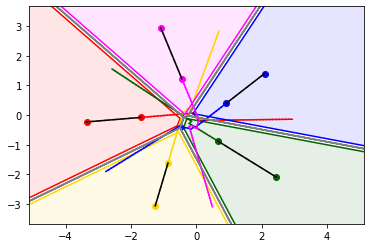

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  49

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.78960721 -0.08690836]
 [-0.89456068 -1.71172398]
 [ 0.74005686 -0.93148576]
 [ 0.99633023  0.46622099]
 [-0.47829102  1.31470312]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.50018599 -0.43554796]
1 .- [-0.38404797 -0.08769328]
2 .- [-0.26739386 -0.02441931]
3 .- [ 42.57636321 -90.68193796]
4 .- [ 98.0929231  -18.05905398]
5 .- [-88.08993605 -48.68527009]
6 .- [-73.40777765  68.23166637]
7 .- [49.6051118  86.65160494]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

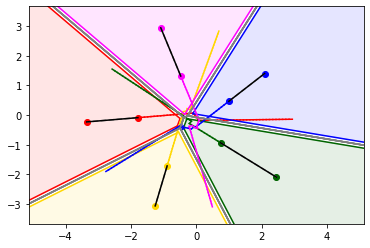

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  50

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.88919465 -0.09598261]
 [-0.92072098 -1.80824154]
 [ 0.822845   -0.98757608]
 [ 1.07238124  0.53115361]
 [-0.51351555  1.40829389]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49975319 -0.44011775]
1 .- [-0.38483527 -0.09056165]
2 .- [-0.27227262 -0.02777681]
3 .- [ 42.0869103  -90.91871242]
4 .- [ 98.4046356 -16.2409747]
5 .- [-87.54133141 -49.67185203]
6 .- [-74.17939535  67.39545841]
7 .- [48.12692305 87.47946779]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

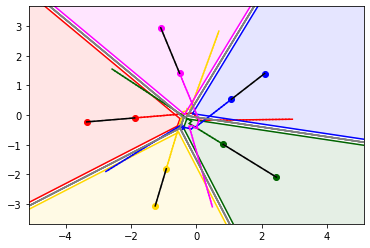

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  51

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-1.98878209 -0.10505685]
 [-0.94688128 -1.90475909]
 [ 0.90563315 -1.04366639]
 [ 1.14843225  0.59608622]
 [-0.54874008  1.50188466]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49937891 -0.44424205]
1 .- [-0.38550997 -0.09310135]
2 .- [-0.27643825 -0.0307844 ]
3 .- [ 41.65188575 -91.12649437]
4 .- [ 98.64502017 -14.67814129]
5 .- [-87.04267617 -50.54671404]
6 .- [-74.85775109  66.64433419]
7 .- [46.80827862 88.19069506]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

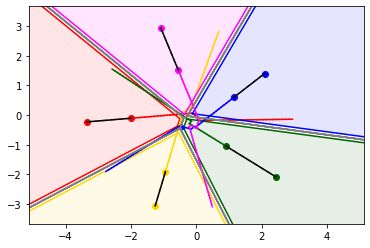

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  52

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.08836953 -0.1141311 ]
 [-0.97304159 -2.00127665]
 [ 0.98842129 -1.0997567 ]
 [ 1.22448326  0.66101883]
 [-0.58396461  1.59547543]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49905231 -0.44798318]
1 .- [-0.38609389 -0.09536509]
2 .- [-0.28002923 -0.03348746]
3 .- [ 41.26271754 -91.31026677]
4 .- [ 98.8332084  -13.32130618]
5 .- [-86.58777924 -51.32755763]
6 .- [-75.45850894  65.96621602]
7 .- [45.62553819 88.80726265]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

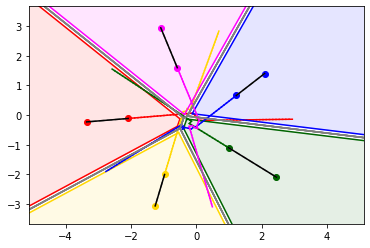

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  53

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.18795697 -0.12320535]
 [-0.99920189 -2.0977942 ]
 [ 1.07120944 -1.15584701]
 [ 1.30053427  0.72595144]
 [-0.61918913  1.68906621]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49876502 -0.45139234]
1 .- [-0.38660371 -0.09739503]
2 .- [-0.28315173 -0.03592564]
3 .- [ 40.91253856 -91.47393865]
4 .- [ 98.98246751 -12.13290206]
5 .- [-86.17136257 -52.0285775 ]
6 .- [-75.99405941  65.35115454]
7 .- [44.55933642 89.34612657]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

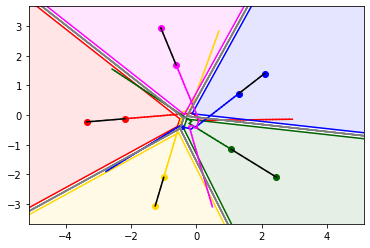

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  54

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.28754441 -0.13227959]
 [-1.0253622  -2.19431176]
 [ 1.15399758 -1.21193732]
 [ 1.37658528  0.79088406]
 [-0.65441366  1.78265698]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49851048 -0.45451196]
1 .- [-0.3870523  -0.09922526]
2 .- [-0.28588819 -0.03813308]
3 .- [ 40.59578401 -91.62061838]
4 .- [ 99.10220209 -11.08383405]
5 .- [-85.78891696 -52.66127937]
6 .- [-76.47432203  64.79089251]
7 .- [43.59370201 89.82054243]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

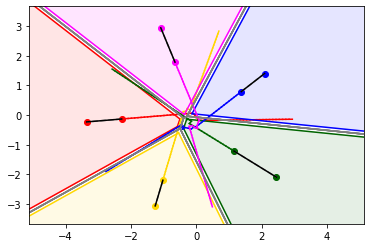

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  55

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.38713185 -0.14135384]
 [-1.0515225  -2.29082932]
 [ 1.23678572 -1.26802764]
 [ 1.45263628  0.85581667]
 [-0.68963819  1.87624775]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49828352 -0.4573775 ]
1 .- [-0.38744978 -0.1008836 ]
2 .- [-0.28830343 -0.04013895]
3 .- [ 40.30789744 -91.7528078 ]
4 .- [ 99.19921005 -10.15125465]
5 .- [-85.43657851 -53.23508154]
6 .- [-76.90732529  64.27852812]
7 .- [42.71537321 90.24099859]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTIC

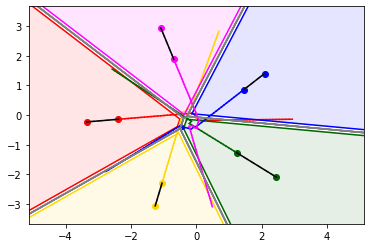

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  56

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.48671929 -0.15042808]
 [-1.0776828  -2.38734687]
 [ 1.31957387 -1.32411795]
 [ 1.52868729  0.92074928]
 [-0.72486272  1.96983852]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49807997 -0.46001885]
1 .- [-0.38780422 -0.10239298]
2 .- [-0.29044893 -0.04196817]
3 .- [ 40.04511278 -91.87254272]
4 .- [99.27849147 -9.3169942 ]
5 .- [-85.11102479 -53.75776336]
6 .- [-77.29963217  63.8082534 ]
7 .- [41.91326481 90.61588614]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

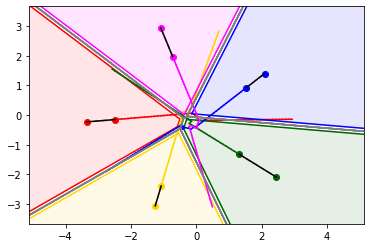

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  57

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.58630672 -0.15950233]
 [-1.10384311 -2.48386443]
 [ 1.40236201 -1.38020826]
 [ 1.6047383   0.98568189]
 [-0.76008725  2.06342929]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49789646 -0.46246138]
1 .- [-0.38812207 -0.10377247]
2 .- [-0.29236604 -0.043642  ]
3 .- [ 39.80429043 -91.98149619]
4 .- [99.34378196 -8.56643569]
5 .- [-84.80938822 -54.23580382]
6 .- [-77.65665677  63.37514958]
7 .- [41.17805137 90.95198691]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

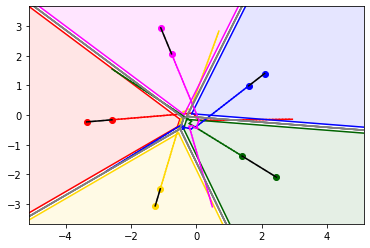

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  58

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.68589416 -0.16857657]
 [-1.13000341 -2.58038198]
 [ 1.48515016 -1.43629857]
 [ 1.68078931  1.05061451]
 [-0.79531177  2.15702007]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49773022 -0.46472677]
1 .- [-0.3884086  -0.10503804]
2 .- [-0.29408828 -0.04517863]
3 .- [ 39.58279245 -92.08105557]
4 .- [99.39791203 -7.8876957 ]
5 .- [-84.52918435 -54.67464022]
6 .- [-77.9829029  62.9750258]
7 .- [40.50183967 91.25483376]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES A

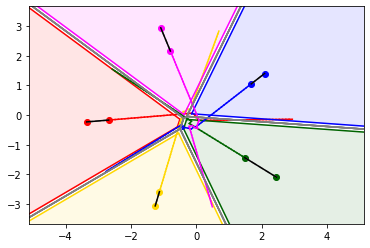

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  59

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.7854816  -0.17765082]
 [-1.15616371 -2.67689954]
 [ 1.5679383  -1.49238888]
 [ 1.75684032  1.11554712]
 [-0.8305363   2.25061084]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49757897 -0.46683363]
1 .- [-0.38866812 -0.10620314]
2 .- [-0.29564309 -0.04659368]
3 .- [ 39.37838639 -92.17238083]
4 .- [99.44305386 -7.27101971]
5 .- [-84.26825232 -55.0788679 ]
6 .- [-78.28214608  62.60429113]
7 .- [39.87790967 91.5289798 ]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

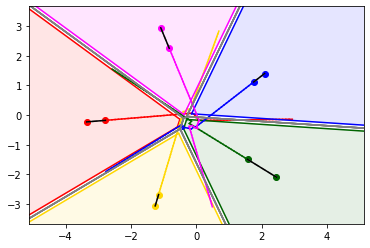

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  60

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.88506904 -0.18672506]
 [-1.18232402 -2.77341709]
 [ 1.65072645 -1.54847919]
 [ 1.83289133  1.18047973]
 [-0.86576083  2.34420161]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.4974408  -0.46879808]
1 .- [-0.3889042  -0.10727923]
2 .- [-0.29705308 -0.04790056]
3 .- [ 39.1891704  -92.25644917]
4 .- [99.4808938  -6.70832967]
5 .- [-84.02470556 -55.45239601]
6 .- [-78.55757386  62.25985222]
7 .- [39.30050845 91.77820205]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

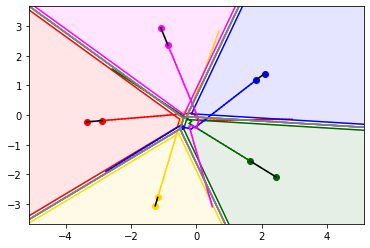

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  61

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-2.98465648 -0.19579931]
 [-1.20848432 -2.86993465]
 [ 1.73351459 -1.60456951]
 [ 1.90894233  1.24541234]
 [-0.90098536  2.43779238]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49731411 -0.47063409]
1 .- [-0.38911982 -0.10827607]
2 .- [-0.29833708 -0.04911088]
3 .- [ 39.01351427 -92.3340895 ]
4 .- [99.51275491 -6.19288137]
5 .- [-83.79689086 -55.7985702 ]
6 .- [-78.81189513  61.93903098]
7 .- [38.76468514 92.00565704]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

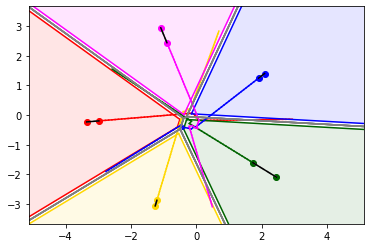

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  62

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.08424392 -0.20487355]
 [-1.23464463 -2.9664522 ]
 [ 1.81630274 -1.66065982]
 [ 1.98499334  1.31034495]
 [-0.93620989  2.53138315]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49719756 -0.47235388]
1 .- [-0.38931747 -0.10920207]
2 .- [-0.29951084 -0.05023467]
3 .- [ 38.85001272 -92.40600954]
4 .- [99.53968527 -5.71900184]
5 .- [-83.58335426 -56.12026997]
6 .- [-79.04742611  61.63949787]
7 .- [38.26615799 92.21400103]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

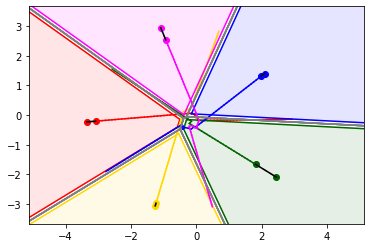

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  63

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.18383136 -0.2139478 ]
 [-1.26       -3.06      ]
 [ 1.89909088 -1.71675013]
 [ 2.06104435  1.37527757]
 [-0.97143441  2.62497393]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.49601256 -0.47032399]
1 .- [-0.38949926 -0.11006448]
2 .- [-0.30058764 -0.05128068]
3 .- [ 38.63374956 -92.49674257]
4 .- [99.56252249 -5.28188616]
5 .- [-83.34379263 -56.47251447]
6 .- [-79.26615852  61.35921747]
7 .- [37.80120658 92.40548369]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

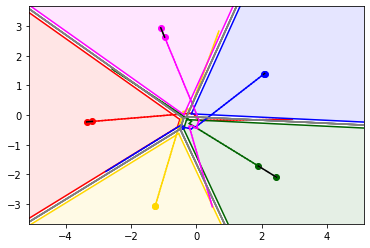

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  64

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.2834188  -0.22302205]
 [-1.26       -3.06      ]
 [ 1.98187903 -1.77284044]
 [ 2.09        1.4       ]
 [-1.00665894  2.7185647 ]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.45982432 -0.34921958]
1 .- [-0.38966701 -0.11086962]
2 .- [-0.37950662 -0.104109  ]
3 .- [ 36.44205602 -93.29141252]
4 .- [99.56248171 -3.50983493]
5 .- [-81.87378977 -58.41613124]
6 .- [-79.46981412  61.09640391]
7 .- [38.7970769  91.90238699]
Robots in front:  [[2 1]
 [2 0]
 [2 4]
 [2 3]
 [1 0]
 [0 4]
 [4 3]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

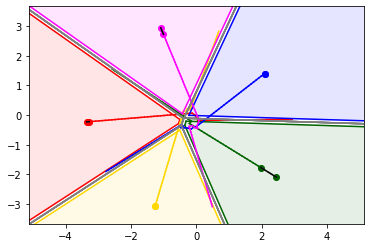

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  65

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [ 2.06466717 -1.82893075]
 [ 2.09        1.4       ]
 [-1.04188347  2.81215547]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.44628978 -0.04596363]
1 .- [-0.40171086 -0.19501584]
2 .- [-0.41451504 -0.23845639]
3 .- [40.65813449 91.11557599]
4 .- [-79.98588475  60.56305246]
5 .- [99.59521163 -0.97954949]
6 .- [ 34.30975289 -94.01598684]
7 .- [-80.71993739 -59.82905248]
Robots in front:  [[4 3]
 [4 0]
 [2 3]
 [2 0]
 [2 1]
 [3 0]
 [0 1]] 

Voronoi Diagram Edges:  [[3, 0], [4, 0], [5, 1], [1, 2], [6, 2], [0, 1], [7, 2]] 

             VORONOI VERTICES

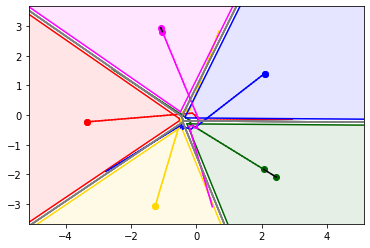

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  66

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [ 2.14745532 -1.88502107]
 [ 2.09        1.4       ]
 [-1.077108    2.90574624]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.48207194  0.07367612]
1 .- [-0.39340384 -0.22279084]
2 .- [-0.31058289 -0.2849994 ]
3 .- [42.45548042 90.38628098]
4 .- [99.67412545  1.46374224]
5 .- [-81.32685977  58.93045381]
6 .- [-80.69882619 -59.81338692]
7 .- [ 32.28834514 -94.82234594]
Robots in front:  [[3 4]
 [3 0]
 [3 1]
 [3 2]
 [4 0]
 [0 1]
 [1 2]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

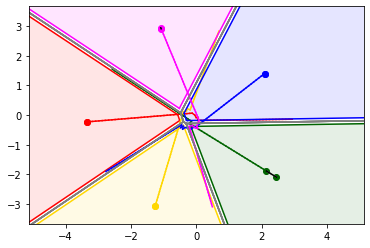

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  67

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [ 2.23024346 -1.94111138]
 [ 2.09        1.4       ]
 [-1.09        2.94      ]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.4947204   0.11596697]
1 .- [-0.39340384 -0.22279084]
2 .- [-0.19803116 -0.36953938]
3 .- [43.09096109 90.11756901]
4 .- [99.71398966  3.82427701]
5 .- [-81.79869089  58.33679127]
6 .- [-80.69882619 -59.81338692]
7 .- [ 30.32930115 -95.59601669]
Robots in front:  [[3 4]
 [3 0]
 [3 1]
 [3 2]
 [4 0]
 [0 1]
 [1 2]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [1, 2], [4, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES

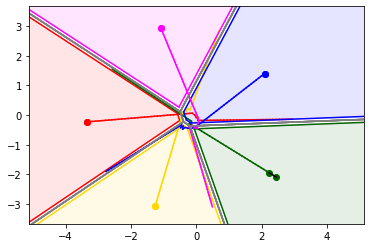

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  68

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [ 2.31303161 -1.99720169]
 [ 2.09        1.4       ]
 [-1.09        2.94      ]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.4947204   0.11596697]
1 .- [-0.39340384 -0.22279084]
2 .- [-0.09200963 -0.44917438]
3 .- [43.09096109 90.11756901]
4 .- [-81.79869089  58.33679127]
5 .- [-80.69882619 -59.81338692]
6 .- [ 28.41846624 -96.29881061]
7 .- [99.69317812  6.10187933]
Robots in front:  [[4 3]
 [4 0]
 [1 3]
 [1 0]
 [1 2]
 [3 0]
 [3 2]] 

Voronoi Diagram Edges:  [[3, 0], [4, 0], [1, 2], [5, 1], [6, 2], [0, 1], [7, 2]] 

             VORONOI VERTICES

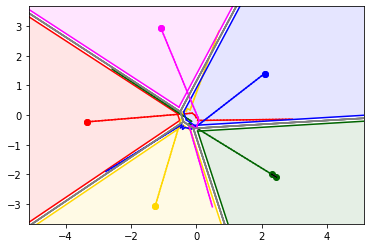

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  69

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.36       -0.23      ]
 [-1.26       -3.06      ]
 [ 2.39581975 -2.053292  ]
 [ 2.09        1.4       ]
 [-1.09        2.94      ]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.4947204   0.11596697]
1 .- [-0.39340384 -0.22279084]
2 .- [ 0.00832565 -0.52453833]
3 .- [43.09096109 90.11756901]
4 .- [-81.79869089  58.33679127]
5 .- [-80.69882619 -59.81338692]
6 .- [ 26.55725701 -96.93591859]
7 .- [99.61848325  8.29682795]
Robots in front:  [[4 3]
 [4 0]
 [1 3]
 [1 0]
 [1 2]
 [3 0]
 [3 2]] 

Voronoi Diagram Edges:  [[3, 0], [4, 0], [1, 2], [5, 1], [6, 2], [0, 1], [7, 2]] 

             VORONOI VERTICES

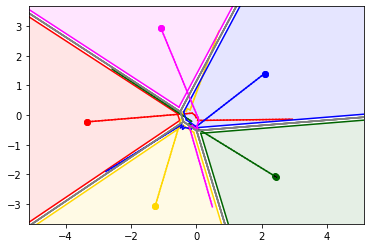

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  70

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

                    MAIN DATA

Robots:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Final positions:
 [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]] 

Colors:
red
gold
darkgreen
blue
magenta


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.4947204   0.11596697]
1 .- [-0.39340384 -0.22279084]
2 .- [ 0.07125354 -0.57180479]
3 .- [43.09096109 90.11756901]
4 .- [99.54344651  9.68893718]
5 .- [-81.79869089  58.33679127]
6 .- [-80.69882619 -59.81338692]
7 .- [ 25.36651775 -97.31967096]
Robots in front:  [[3 4]
 [3 0]
 [3 2]
 [3 1]
 [4 0]
 [0 1]
 [2 1]] 

Voronoi Diagram Edges:  [[3, 0], [0, 1], [4, 2], [1, 2], [5, 0], [6, 1], [7, 2]] 

             VORONOI VERTICES ASSEMBLY
Number of cells: 5 

-----------------------------

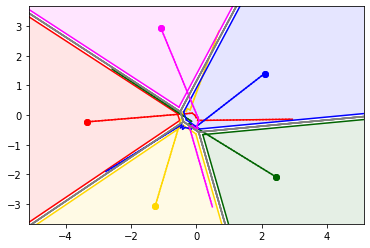

Closer positions: [[-3.36 -0.23]
 [-1.26 -3.06]
 [ 2.45 -2.09]
 [ 2.09  1.4 ]
 [-1.09  2.94]]
Deadlock?: False 


Rounds:  71

*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*

Experiment 0 done!


In [5]:
main_module("robots")

### One Parameter Analysis

In [7]:
parameter = "robots"
print("Working on",parameter,"...")
previous_value = parameters[parameter]
if parameter == "deadlock_mov":
    parameters[parameter] = 1
elif parameter == "tolerance":
    parameters[parameter] = 0.1
elif parameter == "movement":
    parameters[parameter] = 20
for i in range(2):
    print(parameter,"equal to",parameters[parameter],"...")
    main_module(parameter)
    if parameter == "tolerance":
        parameters[parameter] = round(parameters[parameter]+0.1,2)
    elif parameter == "movement":
        parameters[parameter] += 10 
    else:
        parameters[parameter] += 1
parameters[parameter] = previous_value

Working on robots ...
robots equal to 5 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 6 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 

### All Parameter Analysis

In [8]:
for parameter in parameters:
    print("Working on",parameter,"...")
    previous_value = parameters[parameter]
    if parameter == "deadlock_mov":
        parameters[parameter] = 1
    for i in range(10):
        print(parameter,"equal to",parameters[parameter],"...")
        main_module(parameter)
        parameters[parameter] += 1
    parameters[parameter] = previous_value

Working on robots ...
robots equal to 5 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!


voronoi_constructor.ipynb:16: RuntimeWarning: invalid value encountered in double_scalars
  },


Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 6 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 7 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment

KeyboardInterrupt: 

### Generate Video

In [11]:
frameSize = (432, 288)

out = cv2.VideoWriter('/home/leduin/Desktop/Hub/Images/Simple/animation_simple_'
                      +str(robots)+'.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 4,
                      frameSize)

for filename in sorted(glob.glob('/home/leduin/Desktop/Hub/Images/Simple/'
                                 +str(robots)+'/*.png'),
                       key=os.path.getmtime):
    img = cv2.imread(filename)
    out.write(img)

out.release()